In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

**File Pathes**

In [153]:
pwd

'/Users/matthiastitze/Uni HTW/DataScience/Repositories/datafriends_workshop/explore_data'

In [154]:
# File pathes for quick adjustment if places change.
path_input = '00_data_input'
path_temp = '01_data_temp'
path_inter = '02_data_intermediate'
path_output = '03_data_output'
filename_atlas = 'food_atlas.xls'
path_atlas = os.path.join(path_input, filename_atlas)

**Initial Dataframe**

In [155]:
df_health = pd.read_excel(path_atlas, sheet_name='HEALTH')
df_obese = df_health[['FIPS', 'PCT_OBESE_ADULTS08', 'PCT_OBESE_ADULTS13']].copy()
df_obese[:6]

,FIPS,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13
0,1001,31.5,34.1
1,1003,26.2,27.4
2,1005,37.6,44.4
3,1007,32.3,40.3
4,1009,31.9,34.6
5,1011,37.8,43.0


In [156]:
n = len(df_obese.index)
print('{:<25} {:d}'.format('Number of entries:', n))

Number of entries:        3143


**Modified Dataframe**

In [157]:
df_obese.rename(columns={'FIPS':'county_fips','PCT_OBESE_ADULTS08':'PCT_obese_adults_2008', 'PCT_OBESE_ADULTS13':'PCT_obese_adults_2013'}, inplace=True)
df_obese['PCT_obese_adults_average'] = (df_obese['PCT_obese_adults_2008'] + df_obese['PCT_obese_adults_2013'])/2
df_obese['PCT_obese_adults_change'] = df_obese['PCT_obese_adults_2013']- df_obese['PCT_obese_adults_2008']
df_obese[:6]

,county_fips,PCT_obese_adults_2008,PCT_obese_adults_2013,PCT_obese_adults_average,PCT_obese_adults_change
0,1001,31.5,34.1,32.80,2.6
1,1003,26.2,27.4,26.80,1.2
2,1005,37.6,44.4,41.00,6.8
3,1007,32.3,40.3,36.30,8.0
4,1009,31.9,34.6,33.25,2.7
5,1011,37.8,43.0,40.40,5.2


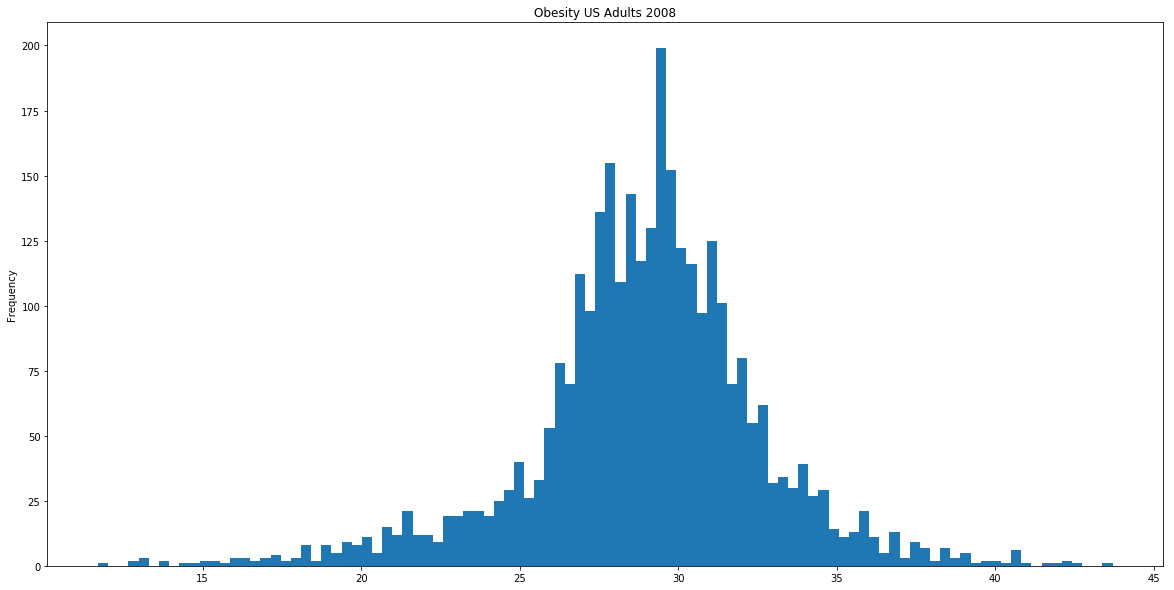

In [158]:
df_obese['PCT_obese_adults_2008'].plot.hist(bins=100, figsize=[20,10], title='Obesity US Adults 2008')

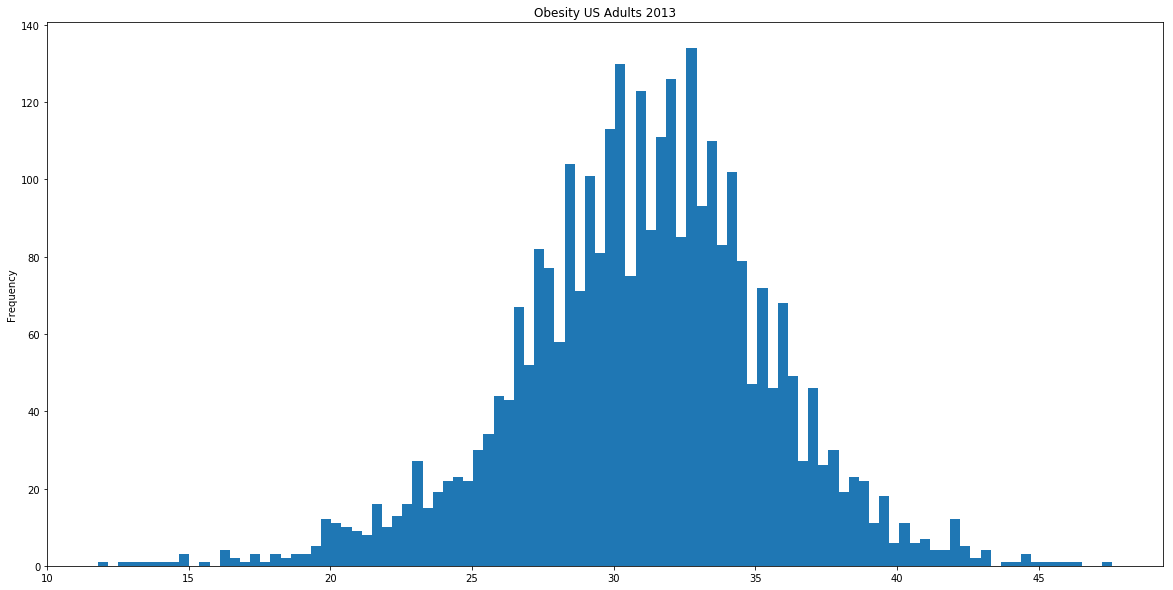

In [159]:
df_obese['PCT_obese_adults_2013'].plot.hist(bins=100, figsize=[20,10], title='Obesity US Adults 2013')

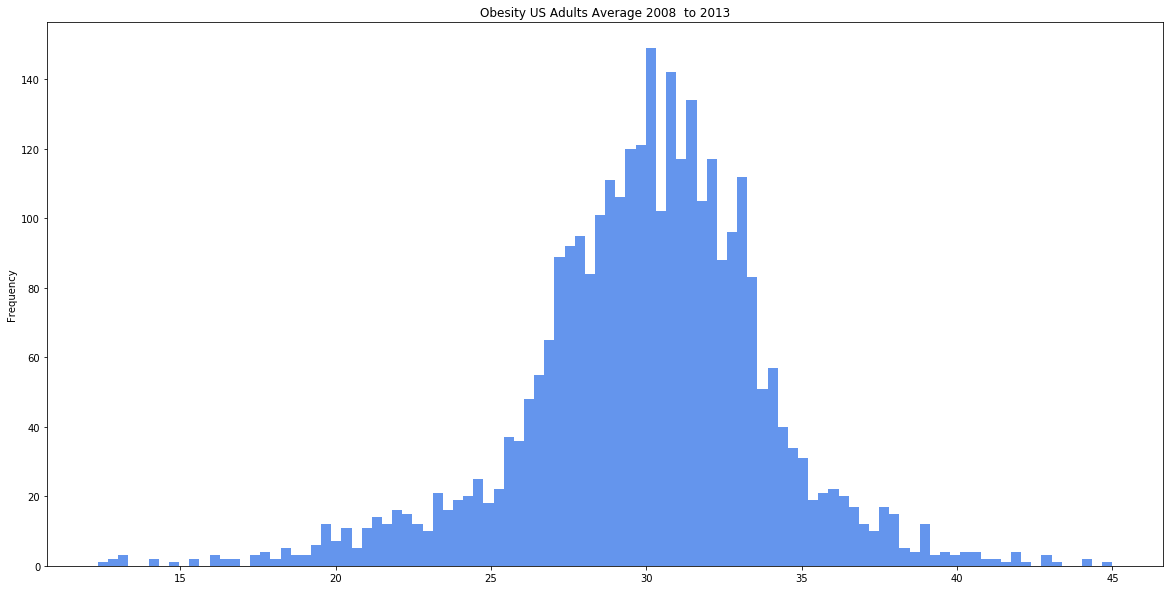

In [160]:
df_obese['PCT_obese_adults_average'].plot.hist(bins=100, figsize=[20,10], \
                                               facecolor='cornflowerblue', \
                                               title='Obesity US Adults Average 2008  to 2013')

In [161]:
series_obese_av = df_obese['PCT_obese_adults_average']
mean_obese_av = series_obese_av.mean()
median_obese_av = series_obese_av.median()
stddev_obese_av = series_obese_av.std()

In [162]:
print('Average adult obesity 2008-2013:')
print('{:<15} {:.3f}'.format('Mean:', mean_obese_av))
print('{:<15} {:.3f}'.format('Median:', median_obese_av))
print('{:<15} {:.3f}'.format('Deviation:', stddev_obese_av))

Average adult obesity 2008-2013:
Mean:           29.974
Median:         30.250
Deviation:      3.935


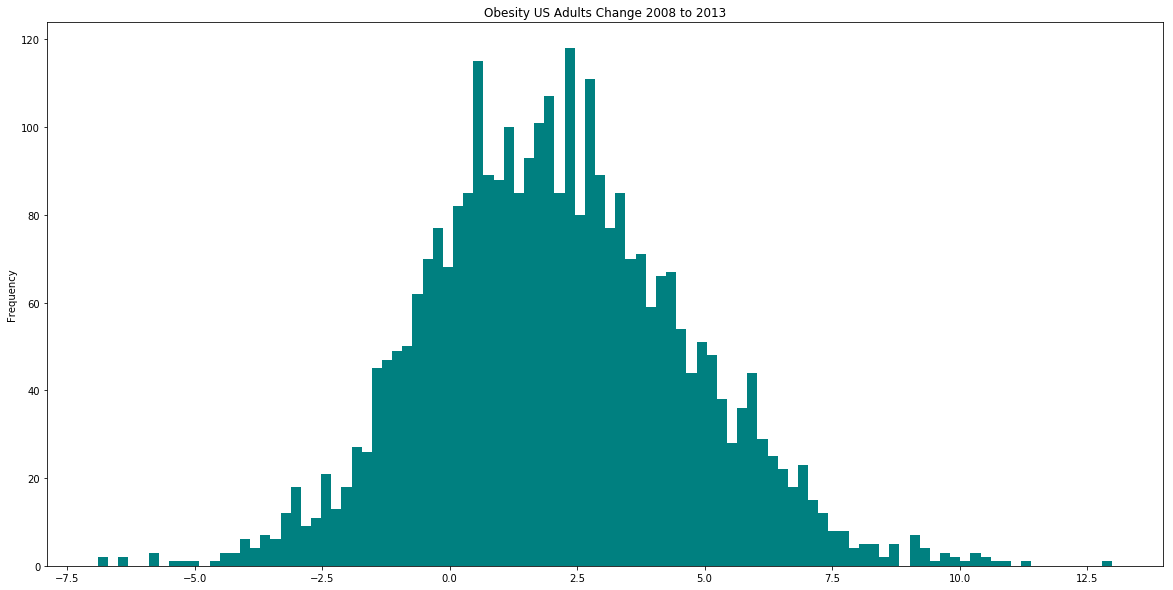

In [163]:
df_obese['PCT_obese_adults_change'].plot.hist(bins=100, figsize=[20,10], \
                                              facecolor='teal', \
                                              title='Obesity US Adults Change 2008 to 2013')

In [164]:
series_obese_change = df_obese['PCT_obese_adults_change']
mean_obese_change = series_obese_change.mean()
median_obese_change = series_obese_change.median()
stddev_obese_change = series_obese_change.std()

In [165]:
print('Change of adult obesity from 2008 to 2013:')
print('{:<15} {:.3f}'.format('Mean:', mean_obese_change))
print('{:<15} {:.3f}'.format('Median:', median_obese_change))
print('{:<15} {:.3f}'.format('Deviation:', stddev_obese_change))

Change of adult obesity from 2008 to 2013:
Mean:           2.086
Median:         2.000
Deviation:      2.566


### Putting Counties into Obesity Groups
We want to throw all counties with a similiar obesity value into one group(e.g. all counties with obesity 22-24%).  
This is the analytic expansion of the obesity historgrams which do not yet carry the associated county information.  
Considering the deviation of the change in obesity from 2008 to 2013 (fluctuation of the data over the years) buckets of range 2% seem adequate.  
This means we form groups starting at 10% ... 12%-14%, 14%-26% ... up to 50%. Each county will land in one of these groups.

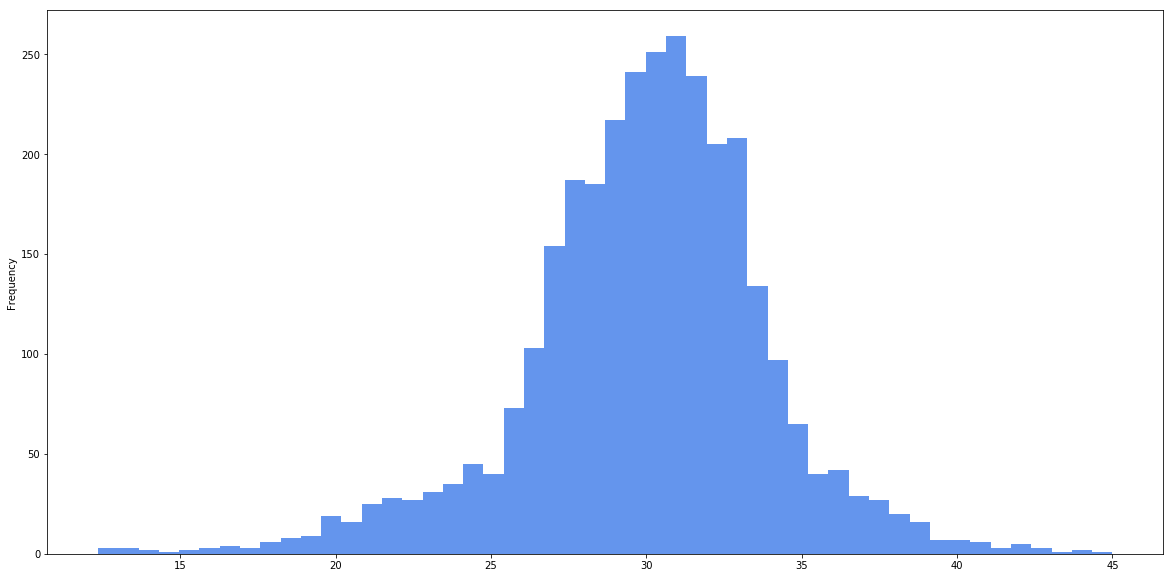

In [166]:
df_obese['PCT_obese_adults_average'].plot.hist(bins=50, figsize=[20,10], facecolor='cornflowerblue')

In [167]:
# Test example of group (bucket) 12-14% adult obeseity rate.
df_obese[(df_obese['PCT_obese_adults_average'] >= 12) & (df_obese['PCT_obese_adults_average'] < 14)]

,county_fips,PCT_obese_adults_2008,PCT_obese_adults_2013,PCT_obese_adults_average,PCT_obese_adults_change
250,8013,13.2,13.4,13.30,0.2
263,8037,12.9,11.8,12.35,-1.1
298,8107,11.7,14.3,13.00,2.6
303,8117,13.0,13.1,13.05,0.1
1821,35049,12.9,13.7,13.30,0.8
3139,56039,13.2,12.7,12.95,-0.5


**Create** obesity group buckets.

In [168]:
# Values defining the obesity ranges thrown into each bucket.
fips_buckets = []
lower_limit = 10
upper_limit = 50
step = 2
bucket_start = lower_limit
bucket_end = bucket_start + step

for i in range(lower_limit, upper_limit, step):
    # Get a sub-dataframe with all the counties whose obesity rates fit into the bucket range.
    df_bucket = df_obese[ \
        (df_obese['PCT_obese_adults_average'] >= bucket_start) & (df_obese['PCT_obese_adults_average'] < bucket_end)]
    # Convert the county fips code column of this sub-dataframe into a list.
    bucket_fips_list = df_bucket['county_fips'].tolist()
    # Create a label describing the obesity rate range of the bucket.
    bucket_description = '%[{}-{}['.format(bucket_start, bucket_end)
    # Package all bucket information into a tupel which we then add to our list of fips-code buckets.
    fips_buckets.append((bucket_description, bucket_fips_list))
    # Move on to the next bucket bz adjusting the obesity range values.
    bucket_start = bucket_end
    bucket_end = bucket_end + step

# Just have a quick look at the format and content of the resulting buckets (easier debugging).
print('Bucket examples (Just a sample for debugging - there are way more fips in each bucket!):')
print('{} : {}'.format(fips_buckets[0][0], fips_buckets[0][1][:10]))
print('{} : {}'.format(fips_buckets[1][0], fips_buckets[1][1][:10]))
print('{} : {}'.format(fips_buckets[2][0], fips_buckets[2][1][:10]))
print('{} : {}'.format(fips_buckets[3][0], fips_buckets[3][1][:10]))

Bucket examples (Just a sample for debugging - there are way more fips in each bucket!):
%[10-12[ : []
%[12-14[ : [8013, 8037, 8107, 8117, 35049, 56039]
%[14-16[ : [8051, 8067, 8097, 36061, 49043]
%[16-18[ : [6041, 6075, 8007, 8015, 8031, 8035, 8045, 8049, 8065, 8069]


**Write** obesity group buckets **to file** for later use in other case.

In [169]:
path_fips_obesity_buckets = os.path.join(path_inter, 'obesity_buckets_fips.csv')
with open(path_fips_obesity_buckets, "w") as f:
    f.write('bucket_index; bucket_range; bucket_size; county_fips\n')
    for i in range(len(fips_buckets)):
        f.write('{};{};{};{}\n'.format(i, fips_buckets[i][0], len(fips_buckets[i][1]), fips_buckets[i][1]))
    print('OK: File saved: {}'.format(path_fips_obesity_buckets))

OK: File saved: 02_data_intermediate/obesity_buckets_fips.csv


### Analysing County Obesity Groups
We want to calculate some additional data to have a closer lock at each obesity group we formed earlier.  
Therefore we create a new dataframe with mean, meadian and standard deviation values for the obesity rates of each group (bucket).

In [170]:
def get_obesity_values_for_fips_list(fips_list, column='PCT_obese_adults_average'):
    '''Gets a list of obesity values - one value for each code in the fips list.'''
    values_list = []
    
    for fips in fips_list:
        # Get the obesity value sub-dataframe for the county fips.
        df_obesity_value = df_obese[df_obese['county_fips']==fips][column]
        # Extract the obesity value we need and add to list.
        obesity_value = df_obesity_value.iloc[0]
        values_list.append(obesity_value)
        
    return values_list

In [219]:
# Set up the layout of the new dataframe.
columns = ['obesity_bucket','n_fips','PCT_obesity_mean','PCT_obesity_median','PCT_obesity_stddev']
df_obesity_groups = pd.DataFrame([],columns=columns)
precision = 3

# Now analyse each obesity group.   
for i in range(len(fips_buckets)):
    # Remenber, the fips (county) buckets group together counties whith a similiar obesity rate.
    bucket_range = fips_buckets[i][0]
    fips_list = fips_buckets[i][1]
    n_fips = len(fips_list)
    
    # Calculate some standard statistical values for each obesity bucket.
    obesity_mean = 0
    obesity_median = 0
    obesity_stddev = 0
    if (n_fips != 0):
        obesity_values = get_obesity_values_for_fips_list(fips_list)
        obesity_mean = round(np.nanmean(obesity_values), precision)
        obesity_median = round(np.nanmedian(obesity_values), precision)
        obesity_stddev = round(np.nanstd(obesity_values), precision)

    # Add a data row for the fips bucket to the new dataframe.
    row = {'obesity_bucket':bucket_range,'n_fips':n_fips, \
           'PCT_obesity_mean':obesity_mean,'PCT_obesity_median':obesity_median,'PCT_obesity_stddev':obesity_stddev}
    df_obesity_groups = df_obesity_groups.append(row, ignore_index=True)
    
df_obesity_groups

,obesity_bucket,n_fips,PCT_obesity_mean,PCT_obesity_median,PCT_obesity_stddev
0,%[10-12[,0,0,0,0
1,%[12-14[,6,12.992,13.025,0.318
2,%[14-16[,5,14.8,14.85,0.507
3,%[16-18[,14,16.979,17.025,0.645
4,%[18-20[,35,19.249,19.5,0.568
5,%[20-22[,63,21.117,21.2,0.559
6,%[22-24[,90,22.988,23.05,0.582
7,%[24-26[,160,25.077,25.15,0.6
8,%[26-28[,444,27.129,27.2,0.552
9,%[28-30[,653,29.051,29.1,0.569


**Poverty Dataframe**

In [180]:
df_social = pd.read_excel(path_atlas, sheet_name='SOCIOECONOMIC')
df_poverty = df_social[['FIPS', 'POVRATE15', 'CHILDPOVRATE15']].copy()
df_poverty.rename(columns={'FIPS':'county_fips','POVRATE15':'PCT_poverty_rate_2015', \
                        'CHILDPOVRATE15':'PCT_poverty_rate_2015_children'}, inplace=True)
df_poverty[:6]

,county_fips,PCT_poverty_rate_2015,PCT_poverty_rate_2015_children
0,1001,12.7,18.8
1,1003,12.9,19.6
2,1005,32.0,45.2
3,1007,22.2,29.3
4,1009,14.7,22.2
5,1011,39.6,51.2


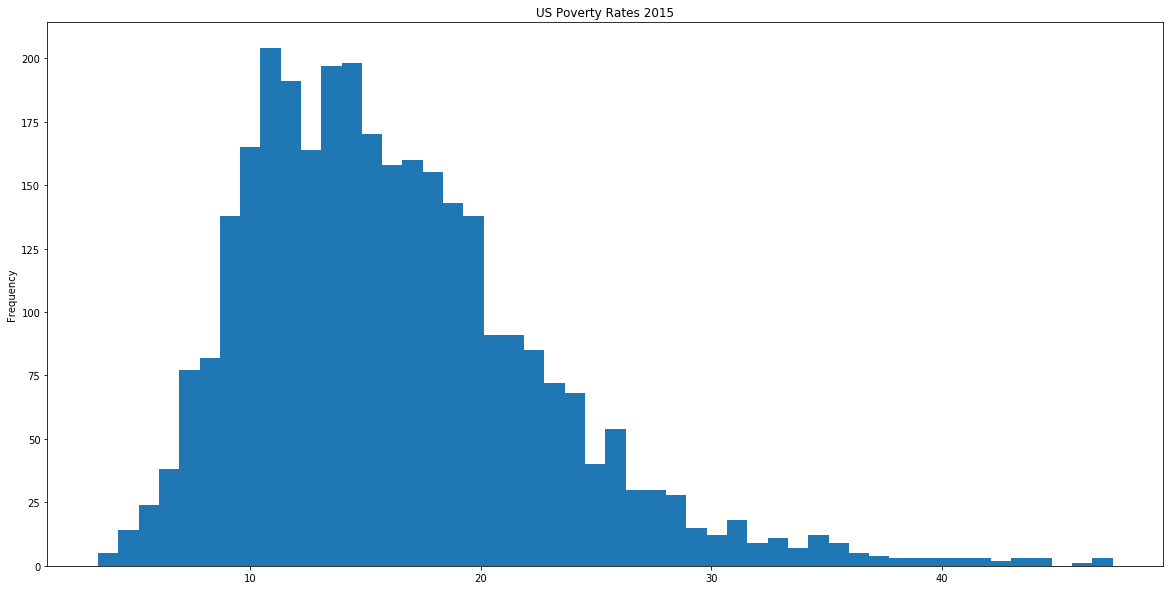

In [245]:
df_poverty['PCT_poverty_rate_2015'].plot.hist(bins=50, figsize=[20,10], title='US Poverty Rates 2015')

In [175]:
def get_poverty_values_for_fips_list(fips_list, column='PCT_poverty_rate_2015'):
    '''Gets a list of poverty values - one value for each code in the fips list.'''
    values_list = []
    
    for fips in fips_list:
        # Get the poverty value sub-dataframe for the county fips.
        df_poverty_value = df_poverty[df_poverty['county_fips']==fips][column]
        # Extract the poverty value we need and add to list.
        poverty_value = df_poverty_value.iloc[0]
        values_list.append(poverty_value)
        
    return values_list

In [229]:
# Set up the layout of the new dataframe.
columns = ['obesity_bucket','PCT_poverty_mean','PCT_poverty_median','PCT_poverty_stddev']
df_poverty_groups = pd.DataFrame([],columns=columns)
precision = 3

# Now analyse each obesity group's poverty values  
for i in range(len(fips_buckets)):
    # Remenber, the fips (county) buckets group together counties whith a similiar obesity rate.
    bucket_range = fips_buckets[i][0]
    fips_list = fips_buckets[i][1]
    n_fips = len(fips_list)
    
    # Calculate some standard statistical values for each obesity bucket.
    poverty_mean = 0
    poverty_median = 0
    poverty_stddev = 0
    if (n_fips != 0):
        poverty_values = get_poverty_values_for_fips_list(fips_list)
        poverty_mean = round(np.nanmean(poverty_values), precision)
        poverty_median = round(np.nanmedian(poverty_values), precision)
        poverty_stddev = round(np.nanstd(poverty_values), precision)

    # Add a data row for the fips bucket to the new dataframe.
    row = {'obesity_bucket':bucket_range, \
           'PCT_poverty_mean':poverty_mean,'PCT_poverty_median':poverty_median,'PCT_poverty_stddev':poverty_stddev}
    df_poverty_groups = df_poverty_groups.append(row, ignore_index=True)

In [230]:
df_obesity_poverty = pd.merge(df_obesity_groups, df_poverty_groups, how='inner', on='obesity_bucket')
df_obesity_poverty

,obesity_bucket,n_fips,PCT_obesity_mean,PCT_obesity_median,PCT_obesity_stddev,PCT_poverty_mean,PCT_poverty_median,PCT_poverty_stddev
0,%[10-12[,0,0,0,0,0,0,0
1,%[12-14[,6,12.992,13.025,0.318,9.533,8.8,2.374
2,%[14-16[,5,14.8,14.85,0.507,10.54,9.4,4.156
3,%[16-18[,14,16.979,17.025,0.645,11.5,11.35,3.877
4,%[18-20[,35,19.249,19.5,0.568,11.674,10.1,4.77
5,%[20-22[,63,21.117,21.2,0.559,14.213,12.9,6.878
6,%[22-24[,90,22.988,23.05,0.582,13.356,13,5.367
7,%[24-26[,160,25.077,25.15,0.6,14.311,13.55,5.46
8,%[26-28[,444,27.129,27.2,0.552,14.291,13.65,5.205
9,%[28-30[,653,29.051,29.1,0.569,13.97,13.3,4.688


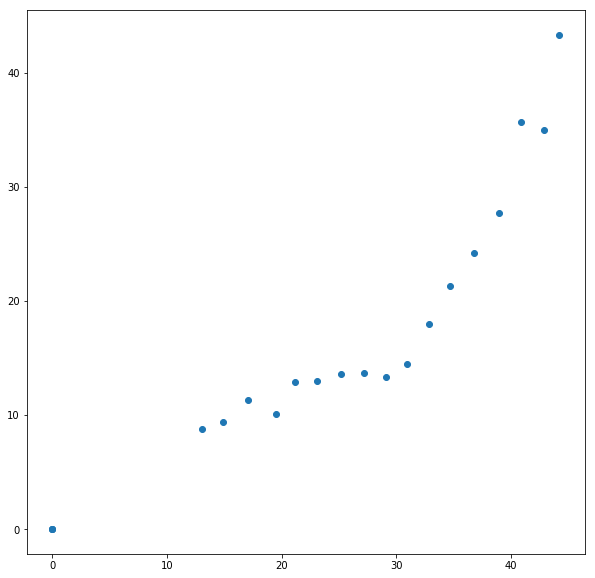

In [249]:
df_plt = df_obesity_poverty[['PCT_obesity_median','PCT_poverty_median']]
plt.rcParams['figure.figsize'] = [10,10]
plt.scatter(df_plt['PCT_obesity_median'].tolist(), df_plt['PCT_poverty_median'].tolist())

**Write** obesity vs. poverty buckets data **to file**.

In [250]:
path_data_obesity_buckets = os.path.join(path_inter, 'obesity_buckets_data.csv')
df_obesity_poverty.to_csv(os.path.join(path_data_obesity_buckets))